In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import jax.random as jr

Véritions que l'on dispose d'un gpu

In [2]:
jax.devices()

[CpuDevice(id=0)]

⇑ Si `[CudaDevice(id=0)]` ne s'affiche pas, allez dans  'Exécution>Modifier le type d'exécussion'.
    Puis choisir un GPU

## Intro


* JAX définit des graphes de calcul, les compile à la première exécution (jit = just time compilation) et  optimise leur exécution (via la lib XLA).
* Les fonctions JAX sont dérivables. Ce qui permet de construire des réseaux de neurone notamment.
* JAX peut exécuter les calculs sur le GPU

## numpy = jax.numpy


Le sous-module numpy de jax est un clone de numpy. Ainsi on n'a pas de nouvelles fonctions à apprendre !

    import jax.numpy as jnp




In [3]:
L = [0, 1, 2, 3]
x_np  =  np.array(L, dtype= np.int32)
x_jnp = jnp.array(L, dtype=jnp.int32)

In [4]:
x_np,x_jnp

(array([0, 1, 2, 3], dtype=int32), Array([0, 1, 2, 3], dtype=int32))

In [5]:
x1 = x_jnp * 2
x2 = x_jnp + 1
x3 = x1 + x2

x1, x2, x3

(Array([0, 2, 4, 6], dtype=int32),
 Array([1, 2, 3, 4], dtype=int32),
 Array([ 1,  4,  7, 10], dtype=int32))

In [ ]:
jnp.dot(x1, x2), jnp.outer(x1, x2)

In [ ]:
np.sin(x_np),jnp.sin(x_jnp)

#### ♡


***À Vous:***

* Quel print ci-dessous correspond à `jnp` et à `np` ?

        (array([0, 1, 2, 3], dtype=int32), Array([0, 1, 2, 3], dtype=int32))


* Quand une fonction `np` prend en gargument un tenseur `jnp` que ce passe-t-il ? Et inversement ?
* Quand on fait une addition d'un tensur `np` et `jnp`, quel est le résultat ?
      


#### ♡♡♡

Faite le tracé suivant avec JAX et matplotlib.

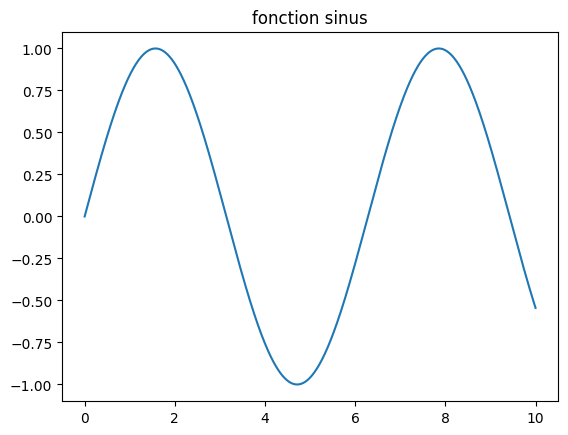

In [ ]:
#--- To keep following outputs, do not run this cell! ---

## Tirage aléatoire

Concept clé: en JAX, on privilégie les fonctions 'pures'.

1. Même entrée => même sortie

2. Une fonction pure  ne fois pas influencer ni être infulencé par des variables globale. Dans le jargons: on dit qu'il ne doit pas y avoir de 'side effect' (effet de bord).


***À vous:*** Pourquoi toutes les fonctions du module `np.random` violent ces 2 principes ?

In [ ]:
#par exemple:
np.random.random([5])

En jax, les fonctions ne s'exécutent pas forcément dans l'ordre où on les écrit (exécussion asynchrone).

In [ ]:
def rand_fn_1():
    return np.random.rand(3)
def rand_fn_2():
    return 10*np.random.rand(3)

In [ ]:
def go(seed):
    np.random.seed(seed)
    print(rand_fn_1()+rand_fn_2())

#we want a reproductible program:
go(32)

Exécutez plusieurs fois la cellule ci-dessus, cela donne toujours le même résultat.

Mais imaginer que le compilateur décide d'exécuter ainsi la fonction `go()`

In [ ]:
def go(seed):
    np.random.seed(seed)
    print(rand_fn_2()+rand_fn_1())

#we want a reproductible program, but we fail.
go(23)

Aille, cela change le résultat.

Voici la solution qu'a trouvée jax:

In [ ]:
def rand_fn_1(key):
    return jax.random.uniform(key,[3])
def rand_fn_2(key):
    return 10*jax.random.uniform(key,[3])

def go(key):
    k1,k2=jax.random.split(key)
    print(rand_fn_2(k1)+rand_fn_1(k1))

Attention: la première clé il faut la générer avec `jax.random.key(un_entier_de_votre_choix)`.

In [ ]:
key=jax.random.key(32)
go(key)

Explication:

* Toutes les fonctions de `jax.random` ont comme premier argument une clé.
* Les clé peuvent se spliter, créant ainsi une arborescence.
* Deux branches distincte dans l'arbre produise des nombre aléatoire "pseudo" indépendants.

Le spliting est déterministe ce qui permet la reproductibilité.   




Pour que tous les tirages aléatoires soient indépendant, il ne faut pas réutiliser une clé que l'on vient de spliter.  


Astuce: on peut détruire la clé mère sur la même ligne que le `split`

In [ ]:
def rand_loop(key):
    for i in range(10):
        key_to_consume, key = jax.random.split(key)
        print(jax.random.uniform(key_to_consume))


rand_loop(jax.random.key(0))

#### ♡♡♡♡♡

***A vous:*** Qu'est-ce qui ne va pas ci-dessous ?

    def rand_loop_2(key):
        for i in range(10):
            key_to_consume, key = jax.random.split(key)
            toto(key)


où `toto` est une fonction qui a besoin d'une clé aléatoire.



***A vous:*** En vous aidant éventuellement d'une IA déterminez:
* Comment fait-on un tirage uniforme sur un intervalle donné ?
* Comment précise-t-on que l'on veut un tenseur de shape donné ?
* Comment fait-t-on un tirage gaussien ?
* Quel est l'ordre des aguments dans les différentes fonctions de `jax.random`?

## sur 32 bits par défaut

In [ ]:
jnp.ones([2,2])

In [ ]:
jnp.arange(4)

In [ ]:
jnp.array(5.5)

Si l'on veut travailler en double précision:

    
    jax.config.update("jax_enable_x64", True)


Alors, toutes les fonctions jax qui crée des tenseur le feront en 64 bit: `jnp.ones, jnp.arange, jnp.random.XXX, jnp.array` etc.

Attention: certain GPU sont lents en 64 bits ! d'autre ne fonctionnent pas du tout.  



## Arguments moins souples que numpy

La plupart des fonctions JAX n'acceptent en entrée que des tableaux NumPy ou JAX. Cela  évite une dégradation silencieuse des performances. Exemple:

In [ ]:
np.stack([[1,2],[3,4]])

In [ ]:
try:
    jnp.stack([[1,2],[3,4]])
except Exception as e:
    print(e)

In [ ]:
#en jax il faut d'abord convertir avant de stacker.
jnp.stack([jnp.array([1,2]),jnp.array([3,4])])

In [ ]:
#Par contre on peut faire comme ceci:
jnp.array([[1,2],[3,4]])

C'est idem avec toutes les fonctions numpy qui prennent des  listes comme entrée. Par exemple `np.meshgrid`, `np.concatenate` etc.

## Pas d'opération in-place

In [ ]:
x = jnp.arange(10)
print(x)
try:
    x[3] = 100
except Exception as e:
    print(e)

Le message dit entre autre: `JAX arrays are immutable` et il nous indique quelle est la bonne syntaxe:

In [ ]:
x = x.at[3].set(100)
x

Attention, piège:

In [ ]:
x.at[5].set(100)
x #ça n'a pas marché

Cela sécurise les programmes. Mais quand on `jit`-compile une fonction, si cela ne pose pas de problème de sécurité, le `at` devient 'inplace' pour gagner en performance.

## Moins d'exception

Pour des raisons de performance: pas d'exception 'out of bounds'.   Mais c'est embêtant à mon avis.

In [ ]:
x=jnp.arange(10)
x[0],x[-1],x[10],x[100]

Et aussi:

In [ ]:
x = x.at[10000].set(999)
x

Heureusement pour débugger:

In [ ]:
import jax.experimental.checkify as checkify

def modify_vec(x):
    return x.at[10].set(999)

x=jnp.arange(5)
err, out =checkify.checkify(modify_vec,errors=checkify.index_checks)(x)

print(err)

In [ ]:
x=jnp.arange(20)
err, out =checkify.checkify(modify_vec,errors=checkify.index_checks)(x)

print(err)

Pas de warning quand on divise par zéro:

In [ ]:
def f():
    return 1/jnp.zeros([3])

f()

In [ ]:
err,out=checkify.checkify(f, errors=checkify.float_checks)()
print(err)

## GPU et Performances

Un tenseur JAX peut être réparti
sur plusieurs processeurs (device), voire
plusieurs hôtes. Par défaut, il utilise un accélérateur disponible.  Mais on peut s'amuser à déplacer un tenseur.

In [3]:
jax.devices()

⇑ si plusieurs accélérateurs Cuda disponible on aurait:

    [CudaDevice(id=0),CudaDevice(id=1),...]

Attention, le nom de l'accélérateur peut changer. Ex, sur mon mac: "CudaDevice" devient "MetalDevice". Sur une carte amd cela devient "RocmDevice".

On prend le premier accélérateur disponible dans la liste:

In [4]:
gpu_device = jax.devices("cuda")[0]

Syntaxe étrange: on sélectionne le cpu, qui n'est pas dans la liste des devices mais qui est quant même dispo bien heureusement !

In [5]:
cpu_device = jax.devices("cpu")[0]

In [6]:
x = jnp.zeros([200, 200])
print(x.devices())
x=jax.device_put(x,cpu_device)
print(x.devices())
x=jax.device_put(x,gpu_device)
print(x.devices())

Variante:

In [11]:
with jax.default_device(cpu_device):
    x = jnp.zeros([200, 200])
    print(x.devices())
    y = jnp.ones([200, 200])
    print(y.devices())
    z=x+y
    print(z.devices())

***A vous:*** Analyser les performances.

In [13]:
size = 3000
key=jr.key(0)

x_jnp = jax.random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

print("on GPU - fast")
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()

print("on CPU - slow (NumPy only works with CPUs)")
%timeit np.dot(x_np, x_np.T)

print("on GPU with transfer overhead")
%timeit jnp.dot(x_np, x_np.T).block_until_ready()

print("push NumPy explicitly to GPU")
x_np_device = jax.device_put(x_np)

print("same as 1")
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()


JAX n'attend pas que l'opération soit terminée avant de renvoyer le contrôle à Python.

`%timeit` lance plusieurs fois la même fonction, sans le `block_until_ready`, exécutions sont faites en parallèles et le temps n'est pas significatif.


### Device mélangés

#### ♡♡♡

***A vous:*** Quand on fait une opération entre des tenseurs sur des devices différent, que ce passe-t-il ? Analyser les codes ci-dessous.

In [ ]:
a=jnp.ones([5])
b=jnp.ones([5])
b=jax.device_put(b,cpu_device)
c=a+b
print(c.devices())

In [ ]:
a=jnp.ones([5])
b=jnp.ones([5])
b=jax.device_put(b,gpu_device)
c=a+b
print(c.devices())

In [ ]:
a=jnp.ones([5])
b=jnp.ones([5])
a=jax.device_put(a,cpu_device)
b=jax.device_put(b,gpu_device)


try:
    c=a+b
    print(c.devices())
except Exception as e:
    print(e)

##  lax

`jax.numpy` est une API qui imite numpy.


`jax.lax` est une API de niveau inférieur qui donne des fonctions plus pointues (donc moins conviviales).



In [ ]:
from jax import lax

In [ ]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)

# NumPy API
result1 = jnp.convolve(x, y)

# lax API
result2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy

print(result1)
print(result2[0][0])
assert np.allclose(result1, result2[0][0], atol=1E-6)

#### ♡♡

***A vous:***

Que se passe-t-il si on ne fait pas le cast explicite `astype(float)` dans le code précédent ?

Vous en déduirez que les fonctions de `lax` sont très peu souples. Vérifiez le avec la fonction `lax.add` par exemple.

## XLA


XLA (Accelerated Linear Algebra) est un compilateur Open Source pour le machine learning. Il est utilisé par PyTorch, TensorFlow et JAX mais c'est sans doute JAX qui l'utilise le mieux.


Remarque:  lax est une anagramme de xla.

## `jax.scipy`

Notons aussi que [`jax.scipy`](https://docs.jax.dev/en/latest/jax.scipy.html) réimplémente de nombreuses fonctionnalités de scipy. Mais avec les atouts de jax en plus.

In [ ]:
from jax.scipy.ndimage import map_coordinates
import numpy as np

# Dimensions de l'image
height, width = 6,6

# Exemple d'image (1 canal, 10x10 pixels)
img = jnp.arange(height*width).reshape(height, width).astype(np.float32)
img

In [ ]:
i_choice=[0,0.1,1,3]
j_choice=[0,0,0,0]
interpo = map_coordinates(img, (i_choice,j_choice), order=1)
interpo

### Défi prog

#### ♡♡♡♡♡♡♡

Utiliser cela pour produire un sous-échantillongage de l'image:

Aide:
* si `i_choice` et `j_choice` sont deux matrices, alors la sortie de `map_coordinates` est une matrice
* utilisez `jnp.meshgrid(...,indexing="ij")`

In [ ]:
#--- To keep following outputs, do not run this cell! ---

Array([[ 0.,  2.,  4.],
       [12., 14., 16.],
       [24., 26., 28.]], dtype=float32)

In [ ]:
jnp.set_printoptions(threshold=10000,precision=2,linewidth=10000)

Ou un sur-échantillonnage (ici de taille 10×10):

In [ ]:
#--- To keep following outputs, do not run this cell! ---

Array([[ 0.  ,  0.56,  1.11,  1.67,  2.22,  2.78,  3.33,  3.89,  4.44,  5.  ],
       [ 3.33,  3.89,  4.44,  5.  ,  5.56,  6.11,  6.67,  7.22,  7.78,  8.33],
       [ 6.67,  7.22,  7.78,  8.33,  8.89,  9.44, 10.  , 10.56, 11.11, 11.67],
       [10.  , 10.56, 11.11, 11.67, 12.22, 12.78, 13.33, 13.89, 14.44, 15.  ],
       [13.33, 13.89, 14.44, 15.  , 15.56, 16.11, 16.67, 17.22, 17.78, 18.33],
       [16.67, 17.22, 17.78, 18.33, 18.89, 19.44, 20.  , 20.56, 21.11, 21.67],
       [20.  , 20.56, 21.11, 21.67, 22.22, 22.78, 23.33, 23.89, 24.44, 25.  ],
       [23.33, 23.89, 24.44, 25.  , 25.56, 26.11, 26.67, 27.22, 27.78, 28.33],
       [26.67, 27.22, 27.78, 28.33, 28.89, 29.44, 30.  , 30.56, 31.11, 31.67],
       [30.  , 30.56, 31.11, 31.67, 32.22, 32.78, 33.33, 33.89, 34.44, 35.  ]], dtype=float32)